## IUGG 2019 plots

Low oxygen pool. The contour C/Csb = 1 is the boundary of the pool. The shelf-break concentration of oxygen Csb in Astoria shelf is 104.071 umol/kg and in Barkley shelf is 84.753 umol/kg.
 
2 versions:
* v1 uses cmo.cm.oxy colormap that colours low and high values red and yellow and middle values gray. So the pool is coloured red.
* v2 uses cmo.cm.ice_r that just colors things in a scale of blues.

In [2]:
#import gsw as sw # Gibbs seawater package
import cmocean as cmo
import matplotlib.gridspec as gspec
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import seaborn as sns
import sys
import canyon_tools.metrics_tools as mpt
import canyon_tools.savitzky_golay as sg

In [3]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, sbdepth)
    return(bathyMasked.mask)

def BottomConc(Tr, hfac, ra, bathy, nz, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = (np.ones(np.shape(BottomInd))*nz - BottomInd) # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[int(BottomInd[i,j]),i,j]
            ConcArea[i,j] = TrBottom*ra[i,j]
            Conc[i,j] = TrBottom
            Area[i,j] = ra[i,j]
                    
        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def getProfile(ptracers_file, mask, trac, xind, yind, zslice, tt):
    
    with Dataset(ptracers_file, 'r') as nbl:
        
        tr = np.ma.masked_array(nbl.variables[trac][tt,zslice,yind,xind], mask = mask[zslice,yind,xind])
       
    return (tr)

def PlotPool(ax,ConcFilt,X,Y,xslice,yslice,colmap, cmin=0.2, cmax=1.8):
    
    BAC = ConcFilt[yslice,xslice]
    levels = [0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3.0]
    mesh = ax.contourf(X[xslice]/1000,Y[yslice]/1000,BAC,levels,
                       vmin=cmin, vmax=cmax, cmap=colmap, 
                      )
    cs = ax.contour(X[xslice]/1000,Y[yslice]/1000,BAC,[0.5,1.0],colors='k')
    plt.clabel(cs, fmt='%1.1f', fontsize=10)
    
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    ax.set_aspect(1)
    return(mesh)


def PlotPoolsTr(ax1,tslice, key, ptr_fileA, 
                xslice_pl, yslice_pl, nz,
                hFacA, rAA, DepthA, XA, YA,sbind,
                sbdepthA=-150,colmap=cmo.cm.delta_r, pool_min=0.2, pool_max=1.8):
    
    sns.set_style('white')
    with Dataset(ptr_fileA, 'r') as nbl:
        ConcAreaLinA, ConcLinA, AreaTrA = BottomConc(np.nanmean(nbl.variables[key][tslice,:,:,:], axis=0),
                                                     hFacA,rAA,DepthA, nz-1,sbdepth=sbdepthA)
        mesh1 = PlotPool(ax1,ConcLinA/nbl.variables[key][0,sbind,50,50],XA, YA,
                         xslice_pl,yslice_pl, colmap, cmin=pool_min, cmax=pool_max)

    ax1.set_facecolor("darkgrey")
    ax1.set_aspect(1)
    return(ax1, mesh1)

def PlotPoolBoundary(ax1, tslice, key, ptr_fileA, 
                     xslice_pl, yslice_pl, nz,
                     hFacA, rAA, DepthA, XA, YA,sbind,color,
                     sbdepthA=-150):
    
    sns.set_style('white')
    with Dataset(ptr_fileA, 'r') as nbl:
        ConcAreaLinA, ConcLinA, AreaTrA = BottomConc(np.nanmean(nbl.variables[key][tslice,:,:,:], axis=0),
                                                     hFacA,rAA,DepthA, nz-1,sbdepth=sbdepthA)
        mesh1 = PlotBdy(ax1,ConcLinA/nbl.variables[key][0,sbind,50,50],XA, YA,
                        xslice_pl,yslice_pl,color)

    ax1.set_aspect(1)
    return(ax1)


In [4]:
tracers = ['Tr01','Tr03','Tr04','Tr08','Tr09']
colours = ['#332288','#117733','#999933','#AA4499', 'dimgray']

labels_exp = ['Astoria', 'ARGO', 'Barkley', 'Pathways']
labels_tra = ['Lin','Oxy','Nit','Met','DIC']
units = ['(muM)m3/s','(umol/kg)m3/s','(muM)m3/s',
         '(nM)m3/s','(umol/kg)m3/s']

In [5]:
ptr_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/ptracersGlob.nc'
grid_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/gridGlob.nc'

ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'
grid_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc'

ptr_fileBNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/02_Bar03_No_Cny/ptracersGlob.nc'
grid_fileBNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/02_Bar03_No_Cny/gridGlob.nc'

ptr_fileANoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/ptracersGlob.nc'
grid_fileANoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/gridGlob.nc'

In [6]:
nz = 104
nt = 19
sb_Ast = 29 # shelf break z-index Astoria
sb_Bar = 39 # shelf break z-index Barkley

with Dataset(grid_fileB, 'r') as nbl:
    ZB = nbl.variables['RC'][:]
    YB = nbl.variables['Y'][:]
    XB = nbl.variables['X'][:]
    hFacB = nbl.variables['HFacC'][:]
    DepthB = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacB, 0)
    maskCB = np.ma.getmask(hfac)
    rAB = nbl.variables['rA'][:]
    
with Dataset(grid_fileA, 'r') as nbl:
    ZA = nbl.variables['RC'][:]
    YA = nbl.variables['Y'][:]
    XA = nbl.variables['X'][:]
    hFacA = nbl.variables['HFacC'][:]
    DepthA = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacA, 0)
    maskCA = np.ma.getmask(hfac)
    rAA = nbl.variables['rA'][:]
    
with Dataset(grid_fileBNoC, 'r') as nbl:
    hFacBNoC = nbl.variables['HFacC'][:]
    hfacNoC = np.ma.masked_values(hFacBNoC, 0)
    maskCBNoC = np.ma.getmask(hfacNoC)
    DepthBNoC = nbl.variables['Depth'][:]
    rABNoC = nbl.variables['rA'][:]
    
with Dataset(grid_fileANoC, 'r') as nbl:
    hFacANoC = nbl.variables['HFacC'][:]
    hfacNoC = np.ma.masked_values(hFacANoC, 0)
    maskCANoC = np.ma.getmask(hfacNoC)
    DepthANoC = nbl.variables['Depth'][:]
    rAANoC = nbl.variables['rA'][:]
    
with Dataset(ptr_fileA, 'r') as nbl:
    time = nbl.variables['T'][:]
    
sb_depthA = ZA[sb_Ast]
sb_depthB = ZB[sb_Bar]


In [7]:
labels_exp = ['Astoria', 'ARGO', 'Barkley', 'Pathways']
labels_tra = ['Linear','Oxygen','Nitrate','Methane','DIC']
units = [r'$\mu$M m$^{3}$s$^{-1}$',r'$\mu$mol kg$^{-1}m$^3$s$^{-1}$',r'$\mu$M m$^3$s$^{-1}$',
         r'nM m$^3$s$^{-1}$',r'$\mu$mol kg$^{-1}$m$^3$s^{-2}']
factors = [1,1,1,1E-3,1]
sb_conc_A = np.empty(len(labels_tra))
sb_conc_B = np.empty(len(labels_tra))

for ii, trac in zip(range(len(tracers)),tracers):
    for pfile,sb_array, sb_ind in zip([ptr_fileB, ptr_fileA],[sb_conc_A, sb_conc_B], [sb_Ast, sb_Bar]):
        with Dataset(pfile, 'r') as nbl:
            tr_profile = nbl.variables[trac][0,:,10,180]
            sb_array[ii] = tr_profile[sb_ind]

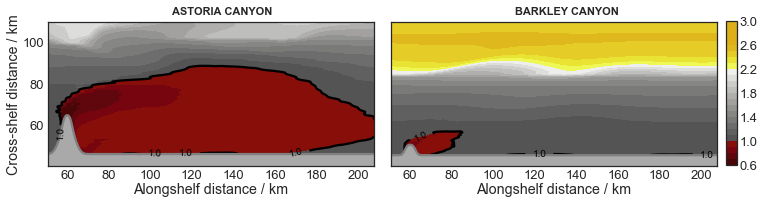

In [8]:
sns.set_style('white')
sns.set_context('talk')
plt.rcParams.update({'font.size': 11})
fig=plt.figure(figsize=(12,5))

gs = gspec.GridSpec(1, 2, hspace=0.05,wspace=0.05)

ax0 = plt.subplot(gs[0])
ax4 = plt.subplot(gs[1])

yslice_pl = slice(110,360)
xslice_pl = slice(120,500)
tslice = slice(10,18)
key = 'Tr03'

# Bottom concetration linear profile (mean during adv. phase)
ax0, mesh0 = PlotPoolsTr(ax0, tslice, key, ptr_fileA, 
                         xslice_pl, yslice_pl, nz,
                         hFacA, rAA, DepthA, XA, YA,sb_Ast,
                         sbdepthA=sb_depthA,colmap=cmo.cm.oxy, pool_min=0.6, pool_max=2.6)
ax0.contour(XA[xslice_pl]/1000, YA[yslice_pl]/1000, DepthA[yslice_pl,xslice_pl],
            [-sb_depthA], colors='0.5')

ax4, mesh4 = PlotPoolsTr(ax4, tslice, key, ptr_fileB, 
                         xslice_pl, yslice_pl, nz,
                         hFacB, rAB, DepthB, XB, YB,sb_Bar,
                         sbdepthA=sb_depthB,colmap=cmo.cm.oxy, pool_min=0.6, pool_max=2.6)
ax4.contour(XB[xslice_pl]/1000, YB[yslice_pl]/1000, DepthB[yslice_pl,xslice_pl],
            [-sb_depthB], colors='0.5')
ax4.yaxis.set_ticks([])
ax0.set_ylabel('Cross-shelf distance / km', labelpad=1)
ax0.set_xlabel('Alongshelf distance / km', labelpad=1)
ax4.set_xlabel('Alongshelf distance / km', labelpad=1)

cbar_ax = fig.add_axes([0.91, 0.305, 0.013, 0.4])
cb=fig.colorbar(mesh4, cax=cbar_ax,ticks=[0.6,1.0,1.4,1.8,2.2,2.6,3],
                format='%1.1f')
cb.ax.yaxis.set_tick_params(pad=2)
ax0.xaxis.set_tick_params(pad=4)
ax0.yaxis.set_tick_params(pad=4)
ax4.xaxis.set_tick_params(pad=4)

ax0.text(0.38,1.05,'ASTORIA CANYON',fontweight='bold',transform=ax0.transAxes)
ax4.text(0.38,1.05,'BARKLEY CANYON',fontweight='bold',transform=ax4.transAxes)

plt.savefig('06_low_oxygen_pool_v1.pdf',format='pdf', bbox_inches='tight')    

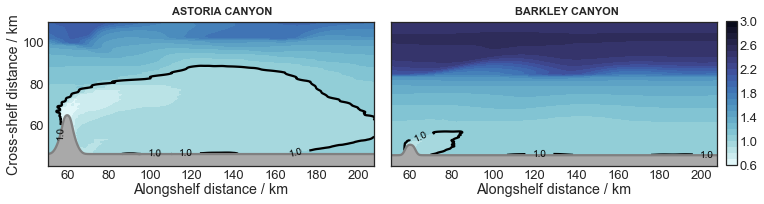

In [9]:
sns.set_style('white')
sns.set_context('talk')
plt.rcParams.update({'font.size': 11})
fig=plt.figure(figsize=(12,5))

gs = gspec.GridSpec(1, 2, hspace=0.05,wspace=0.05)

ax0 = plt.subplot(gs[0])
ax4 = plt.subplot(gs[1])

yslice_pl = slice(110,360)
xslice_pl = slice(120,500)
tslice = slice(10,18)
key = 'Tr03'

# Bottom concetration linear profile (mean during adv. phase)
ax0, mesh0 = PlotPoolsTr(ax0, tslice, key, ptr_fileA, 
                         xslice_pl, yslice_pl, nz,
                         hFacA, rAA, DepthA, XA, YA,sb_Ast,
                         sbdepthA=sb_depthA,colmap=cmo.cm.ice_r, pool_min=0.6, pool_max=3.0)
ax0.contour(XA[xslice_pl]/1000, YA[yslice_pl]/1000, DepthA[yslice_pl,xslice_pl],
            [-sb_depthA], colors='0.5')

ax4, mesh4 = PlotPoolsTr(ax4, tslice, key, ptr_fileB, 
                         xslice_pl, yslice_pl, nz,
                         hFacB, rAB, DepthB, XB, YB,sb_Bar,
                         sbdepthA=sb_depthB,colmap=cmo.cm.ice_r, pool_min=0.6, pool_max=3.0)
ax4.contour(XB[xslice_pl]/1000, YB[yslice_pl]/1000, DepthB[yslice_pl,xslice_pl],
            [-sb_depthB], colors='0.5')
ax4.yaxis.set_ticks([])
ax0.set_ylabel('Cross-shelf distance / km', labelpad=1)
ax0.set_xlabel('Alongshelf distance / km', labelpad=1)
ax4.set_xlabel('Alongshelf distance / km', labelpad=1)

cbar_ax = fig.add_axes([0.91, 0.305, 0.013, 0.4])
cb=fig.colorbar(mesh4, cax=cbar_ax,ticks=[0.6,1.0,1.4,1.8,2.2,2.6,3.0],
                format='%1.1f')
cb.ax.yaxis.set_tick_params(pad=2)
ax0.xaxis.set_tick_params(pad=4)
ax0.yaxis.set_tick_params(pad=4)
ax4.xaxis.set_tick_params(pad=4)

ax0.text(0.38,1.05,'ASTORIA CANYON',fontweight='bold',transform=ax0.transAxes)
ax4.text(0.38,1.05,'BARKLEY CANYON',fontweight='bold',transform=ax4.transAxes)

plt.savefig('06_low_oxygen_pool_v2.pdf',format='pdf', bbox_inches='tight')    

In [10]:
print('Shelf break concentration of oxygen in Astoria shelf is %1.3f umol/kg' %sb_conc_A[1])
print('Shelf break concentration of oxygen in Barkley shelf is %1.3f umol/kg' %sb_conc_B[1])

Shelf break concentration of oxygen in Astoria shelf is 104.071 umol/kg
Shelf break concentration of oxygen in Barkley shelf is 84.753 umol/kg
